# PROBLEM 1
#### OBJECTIVE:
- Develop a predictive model that can determine whether a patient will be eligible for "Target Drug" treatment in the next 30 days.
- The model should be based on patient data such as demographics, medical history, and current health status.
- The goal is to help physicians make informed decisions on which treatments to give to their patients.

IMPORTING LIBRARIES

In [68]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#To supress Warnings
import warnings
warnings.filterwarnings("ignore")

# Visualization modifires
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
sns.set(style = 'darkgrid',font_scale=1.5)
%matplotlib inline

# DATA UNDERSTANDING

TRAINING DATA

In [69]:
df_train = pd.read_parquet("train.parquet") # loading parquet file

In [70]:
df_train.shape # checking shape

(3220868, 3)

In [71]:
df_train.head() # first 5 rows

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [72]:
df_train.tail() #last 5 rows

,Patient-Uid,Date,Incident
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6
29080911,a0ee146e-1c7c-11ec-baee-16262ee38c7f,2018-10-05,DRUG_TYPE_1


In [73]:
df_train.info()  # information about data set

<class 'pandas.core.frame.DataFrame'>
Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[us]
 2   Incident     object        
dtypes: datetime64[us](1), object(2)
memory usage: 98.3+ MB


In [74]:
df_train.nunique() # column wise unique values

Patient-Uid    27033
Date            1977
Incident          57
dtype: int64

In [75]:
df_train['Incident'].unique() # unique values in Incident

array(['PRIMARY_DIAGNOSIS', 'SYMPTOM_TYPE_0', 'DRUG_TYPE_0',
       'DRUG_TYPE_1', 'DRUG_TYPE_2', 'TEST_TYPE_0', 'DRUG_TYPE_3',
       'DRUG_TYPE_4', 'DRUG_TYPE_5', 'DRUG_TYPE_6', 'DRUG_TYPE_8',
       'DRUG_TYPE_7', 'SYMPTOM_TYPE_1', 'DRUG_TYPE_10', 'SYMPTOM_TYPE_29',
       'SYMPTOM_TYPE_2', 'DRUG_TYPE_11', 'DRUG_TYPE_9', 'DRUG_TYPE_13',
       'SYMPTOM_TYPE_5', 'TEST_TYPE_1', 'SYMPTOM_TYPE_6', 'TEST_TYPE_2',
       'SYMPTOM_TYPE_3', 'SYMPTOM_TYPE_8', 'DRUG_TYPE_14', 'DRUG_TYPE_12',
       'SYMPTOM_TYPE_9', 'SYMPTOM_TYPE_10', 'SYMPTOM_TYPE_7',
       'SYMPTOM_TYPE_11', 'TEST_TYPE_3', 'DRUG_TYPE_15', 'SYMPTOM_TYPE_4',
       'SYMPTOM_TYPE_14', 'SYMPTOM_TYPE_13', 'SYMPTOM_TYPE_16',
       'SYMPTOM_TYPE_17', 'SYMPTOM_TYPE_15', 'SYMPTOM_TYPE_18',
       'SYMPTOM_TYPE_12', 'SYMPTOM_TYPE_20', 'SYMPTOM_TYPE_21',
       'DRUG_TYPE_17', 'SYMPTOM_TYPE_22', 'TEST_TYPE_4',
       'SYMPTOM_TYPE_23', 'DRUG_TYPE_16', 'TEST_TYPE_5',
       'SYMPTOM_TYPE_19', 'SYMPTOM_TYPE_24', 'SYMPTOM_TYPE_25',
   

TESTING DATA

In [76]:
df_test = pd.read_parquet("test.parquet")

In [77]:
df_test.shape

(1065524, 3)

In [78]:
df_test.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [79]:
df_test.tail()

,Patient-Uid,Date,Incident
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8
1372859,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-19,DRUG_TYPE_7


In [80]:
df_test.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 1065524 entries, 0 to 1372859
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Patient-Uid  1065524 non-null  object        
 1   Date         1065524 non-null  datetime64[us]
 2   Incident     1065524 non-null  object        
dtypes: datetime64[us](1), object(2)
memory usage: 32.5+ MB


In [81]:
df_test.nunique()

Patient-Uid    11482
Date            1947
Incident          55
dtype: int64

In [82]:
df_test['Incident'].unique()

array(['SYMPTOM_TYPE_0', 'DRUG_TYPE_0', 'DRUG_TYPE_2', 'DRUG_TYPE_1',
       'PRIMARY_DIAGNOSIS', 'DRUG_TYPE_8', 'TEST_TYPE_0', 'DRUG_TYPE_7',
       'DRUG_TYPE_11', 'SYMPTOM_TYPE_6', 'DRUG_TYPE_5', 'DRUG_TYPE_6',
       'DRUG_TYPE_9', 'DRUG_TYPE_15', 'TEST_TYPE_3', 'SYMPTOM_TYPE_3',
       'TEST_TYPE_1', 'DRUG_TYPE_3', 'TEST_TYPE_2', 'SYMPTOM_TYPE_7',
       'DRUG_TYPE_12', 'SYMPTOM_TYPE_2', 'SYMPTOM_TYPE_10',
       'SYMPTOM_TYPE_1', 'SYMPTOM_TYPE_17', 'SYMPTOM_TYPE_18',
       'SYMPTOM_TYPE_5', 'SYMPTOM_TYPE_15', 'SYMPTOM_TYPE_9',
       'SYMPTOM_TYPE_4', 'SYMPTOM_TYPE_8', 'SYMPTOM_TYPE_29',
       'DRUG_TYPE_13', 'SYMPTOM_TYPE_21', 'DRUG_TYPE_4',
       'SYMPTOM_TYPE_12', 'SYMPTOM_TYPE_11', 'SYMPTOM_TYPE_19',
       'DRUG_TYPE_14', 'SYMPTOM_TYPE_16', 'TEST_TYPE_4', 'DRUG_TYPE_10',
       'SYMPTOM_TYPE_26', 'SYMPTOM_TYPE_14', 'SYMPTOM_TYPE_24',
       'DRUG_TYPE_16', 'SYMPTOM_TYPE_13', 'TEST_TYPE_5',
       'SYMPTOM_TYPE_20', 'SYMPTOM_TYPE_25', 'SYMPTOM_TYPE_22',
       'DRUG_TYPE_1

# DATA PREPROCESSING

HANDLING DUPLICATES

In [83]:
df_train.duplicated().sum() # checking duplicates

35571

In [84]:
df_train = df_train.drop_duplicates() #dropping duplicates

In [85]:
df_train.duplicated().sum() # verifying no dup

0

In [86]:
df_train.shape

(3185297, 3)

In [87]:
df_test.duplicated().sum()

12100

In [88]:
df_test = df_test.drop_duplicates()

In [89]:
df_test.duplicated().sum()

0

HANDLING NULL VALUES

In [90]:
df_train.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

 EDA - Exploratory Data Analysis

TRAINING DATA

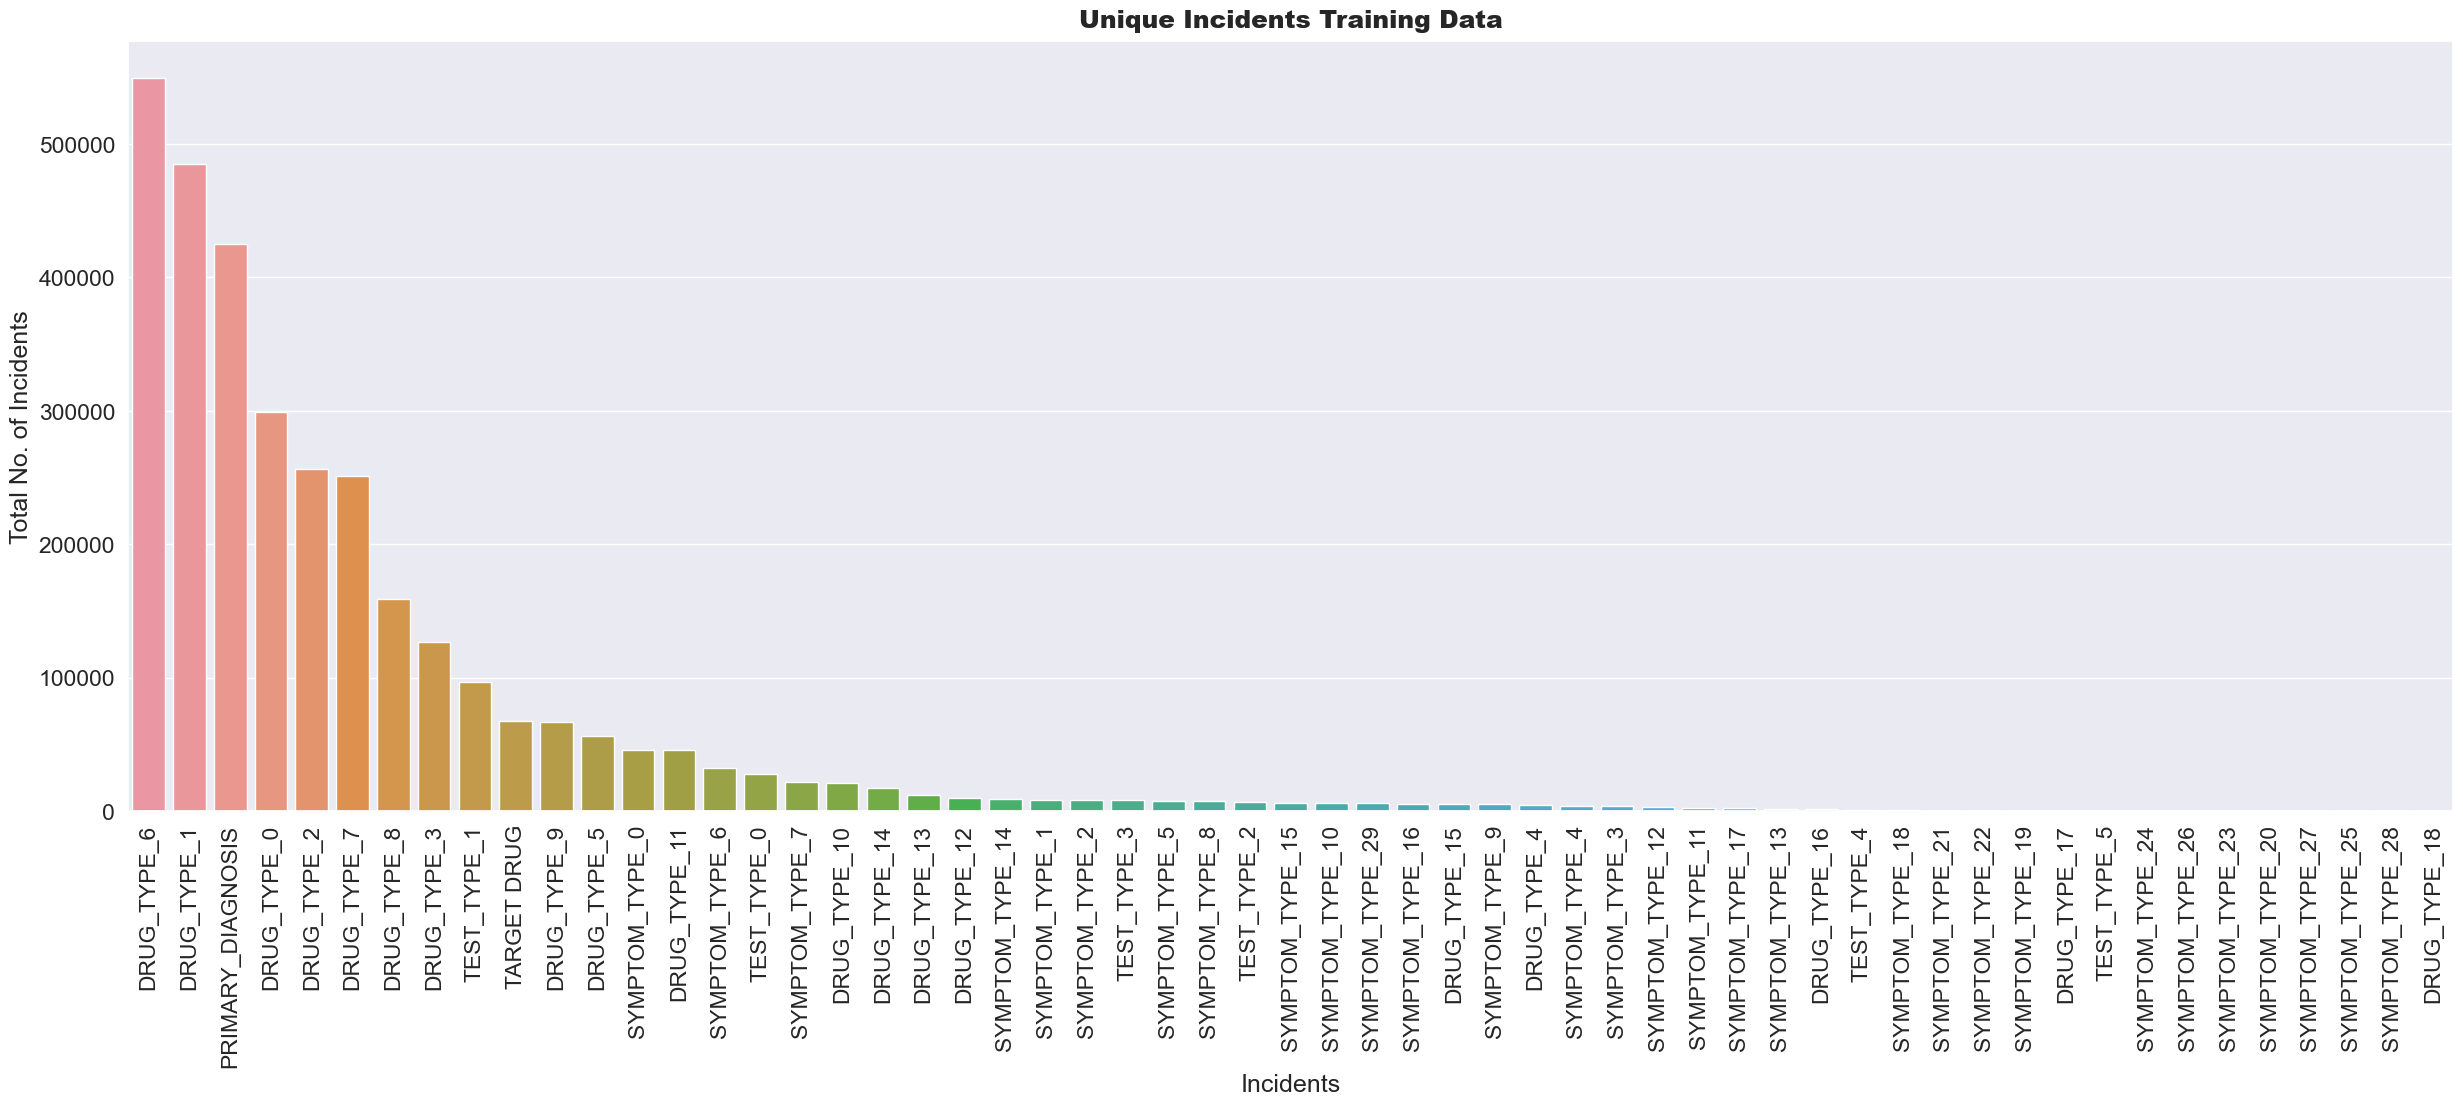

In [91]:
# visualising Incident column in training data
plt.figure(figsize=(30,10))
incident = df_train["Incident"].value_counts()
sns.barplot(x=incident.index, y=incident.values)
plt.xlabel("Incidents")
plt.ylabel("Total No. of Incidents")
plt.title("Unique Incidents Training Data", pad=10, fontweight="black")
plt.xticks(rotation=90)
plt.show()

TESTING DATA

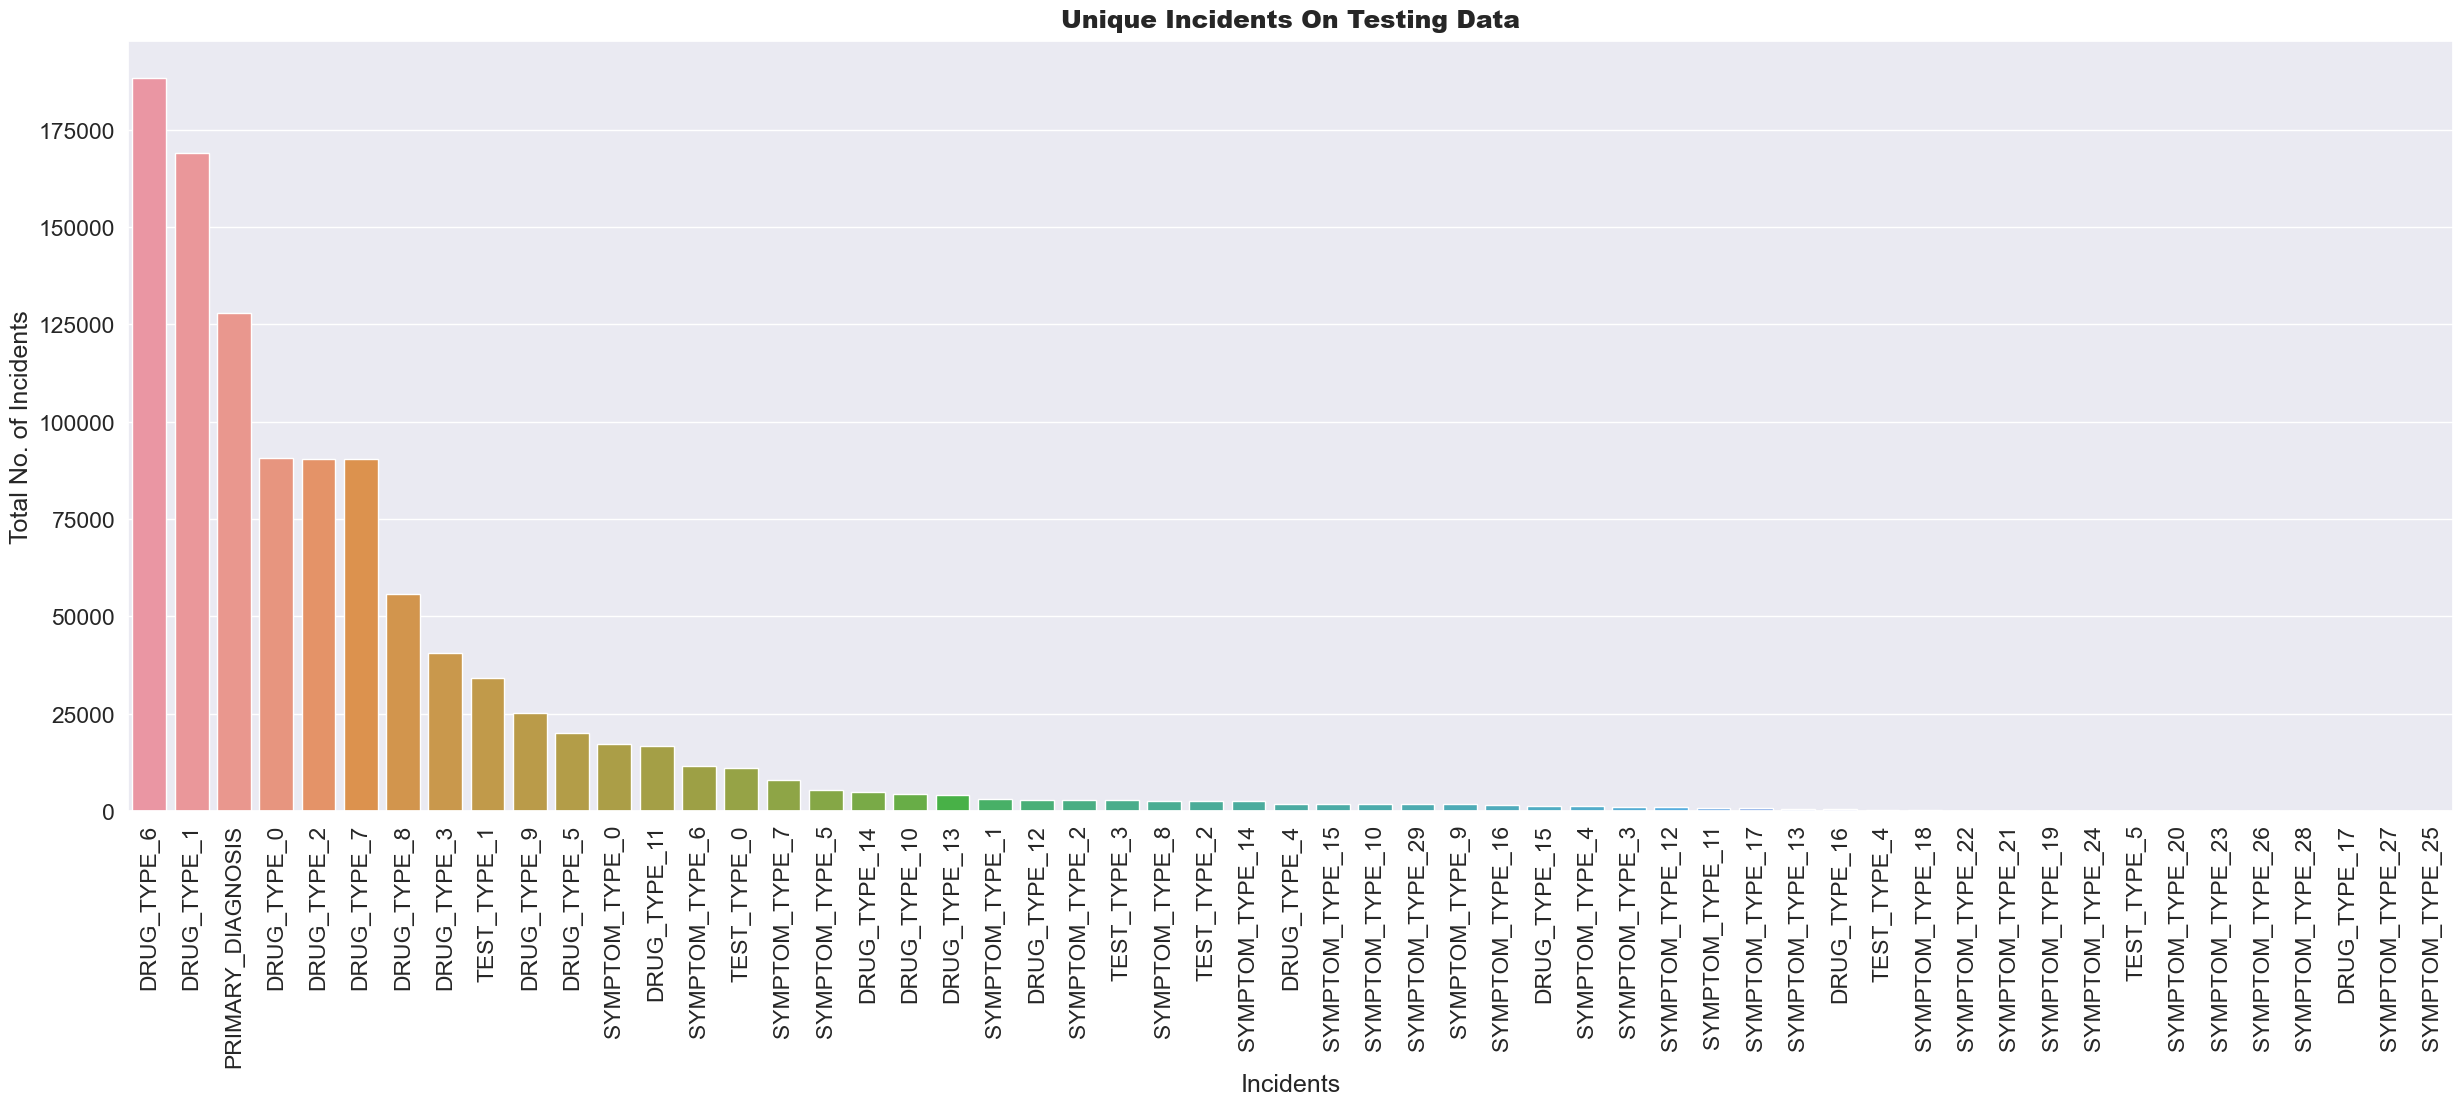

In [92]:
# visualising Incident column in testing data
plt.figure(figsize=(30,10))
incident = df_test["Incident"].value_counts()
sns.barplot(x=incident.index, y=incident.values)
plt.xlabel("Incidents")
plt.ylabel("Total No. of Incidents")
plt.title("Unique Incidents On Testing Data", pad=10, fontweight="black")
plt.xticks(rotation=90)
plt.show()

REMOVING SPACE FROM TARGET DRUG

In [93]:
#removing space from target variables or else troubles in model building
df_train['Incident'] = df_train['Incident'].replace('TARGET DRUG', 'TARGET_DRUG') 

# POSITIVE DATA(INCLUDE-Target Drug)

In [94]:
df_pos = df_train[df_train['Incident']=='TARGET_DRUG'] # incident column includes only target drug
df_pos.head()

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET_DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET_DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET_DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET_DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET_DRUG


In [95]:
df_pos.shape

(67218, 3)

# NEGATIVE DATA(EXCLUDE-Target Drug)

In [96]:
neg =  df_train[~df_train['Patient-Uid'].isin(df_pos['Patient-Uid'])] #incident column excludes target drug
df_neg = neg.groupby('Patient-Uid').tail(1)
df_neg

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS
...,...,...,...
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6


In [97]:
df_neg.shape

(17659, 3)

In [98]:
# interval based count of previous prescriptions on positive data
df_pos['no_of_prescription'] = df_pos.groupby('Patient-Uid')['Date'].cumcount() 

In [99]:
df_pos.head(3)

,Patient-Uid,Date,Incident,no_of_prescription
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET_DRUG,0
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET_DRUG,0
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET_DRUG,0


In [100]:
df_pos.tail(3)

,Patient-Uid,Date,Incident,no_of_prescription
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET_DRUG,10
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET_DRUG,14
29080178,a0eef180-1c7c-11ec-8de8-16262ee38c7f,2018-07-17,TARGET_DRUG,13


In [101]:
# interval based count of previous prescriptions on negative data
df_neg['no_of_prescription'] = df_neg.groupby('Patient-Uid')['Date'].cumcount()

In [102]:
df_neg.head(3)

,Patient-Uid,Date,Incident,no_of_prescription
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0


In [103]:
df_neg.tail(3)

,Patient-Uid,Date,Incident,no_of_prescription
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS,0
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6,0
3256805,a0e69331-1c7c-11ec-a98d-16262ee38c7f,2015-10-03,DRUG_TYPE_6,0


In [104]:
# difference between the most recent prescription and prediction date.
pred_date = pd.to_datetime('today') + pd.DateOffset(days=30)
df_pos['Last_pres-Target'] = (pred_date - df_pos.groupby('Patient-Uid')['Date'].transform('max')).dt.days
df_neg['Last_pres-Target'] = (pred_date - df_neg.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [105]:
df_pos.head(3)

,Patient-Uid,Date,Incident,no_of_prescription,Last_pres-Target
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET_DRUG,0,1197
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET_DRUG,0,1451
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET_DRUG,0,1476


In [106]:
df_pos.tail(3)

,Patient-Uid,Date,Incident,no_of_prescription,Last_pres-Target
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET_DRUG,10,1190
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET_DRUG,14,1197
29080178,a0eef180-1c7c-11ec-8de8-16262ee38c7f,2018-07-17,TARGET_DRUG,13,1388


In [107]:
df_neg.head(3)

,Patient-Uid,Date,Incident,no_of_prescription,Last_pres-Target
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0,2027
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0,3152
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0,1919


In [108]:
df_neg.tail(3)

,Patient-Uid,Date,Incident,no_of_prescription,Last_pres-Target
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS,0,1570
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6,0,2468
3256805,a0e69331-1c7c-11ec-a98d-16262ee38c7f,2015-10-03,DRUG_TYPE_6,0,2973


# FINAL DF (POS + NEG)

In [109]:
# concatenation of positive and negative df
final_df = pd.concat([df_pos, df_neg])
final_df.head(10)

,Patient-Uid,Date,Incident,no_of_prescription,Last_pres-Target
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET_DRUG,0,1197
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET_DRUG,0,1451
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET_DRUG,0,1476
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET_DRUG,0,1181
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET_DRUG,0,1197
3309499,a0ea694f-1c7c-11ec-bb23-16262ee38c7f,2018-11-22,TARGET_DRUG,0,1197
3317468,a0efffd7-1c7c-11ec-af4c-16262ee38c7f,2019-03-23,TARGET_DRUG,0,1211
3320603,a0eaab85-1c7c-11ec-b6b0-16262ee38c7f,2019-09-18,TARGET_DRUG,0,1239
3320605,a0eab6ec-1c7c-11ec-aa1a-16262ee38c7f,2019-06-15,TARGET_DRUG,0,1213
3330839,a0ed0a16-1c7c-11ec-820b-16262ee38c7f,2019-09-14,TARGET_DRUG,0,1408


In [110]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84877 entries, 3294791 to 3256805
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Patient-Uid         84877 non-null  object        
 1   Date                84877 non-null  datetime64[us]
 2   Incident            84877 non-null  object        
 3   no_of_prescription  84877 non-null  int64         
 4   Last_pres-Target    84877 non-null  int64         
dtypes: datetime64[us](1), int64(2), object(2)
memory usage: 3.9+ MB


In [111]:
final_df.shape

(84877, 5)

# DATA SPLITTING

In [112]:
# splitting data into x and y 
X = final_df[['no_of_prescription', 'Last_pres-Target']]
y = final_df['Incident'] == 'TARGET_DRUG'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [113]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape #shape of the splitted df

((63657, 2), (21220, 2), (63657,), (21220,))

# MODEL BUILDING

In [114]:
#logistic regression model
Logistic_Regression = LogisticRegression()
Logistic_Regression.fit(X_train, y_train)
y_pred_lr = Logistic_Regression.predict(X_test)

lr_AUROC = roc_auc_score(y_test, y_pred_lr)*100
lr_Acu = accuracy_score(y_test, y_pred_lr)*100
lr_f1 = f1_score(y_test, y_pred_lr)


print("F1 SCORE OF Logistic Regression : ", lr_f1 )
print("Accuracy OF Logistic Regression : ", lr_Acu)

F1 SCORE OF Logistic Regression :  0.9603054790871148
Accuracy OF Logistic Regression :  93.68049010367578


In [115]:
# random forest model
Random_Forest = RandomForestClassifier()
Random_Forest.fit(X_train, y_train)
y_pred_rf = Random_Forest.predict(X_test)

rf_AUROC = roc_auc_score(y_test, y_pred_rf)*100
rf_Acu = accuracy_score(y_test, y_pred_rf)*100
rf_f1 = f1_score(y_test, y_pred_rf)

print("F1 SCORE OF Random_Forest : ", rf_f1 )
print("Accuracy OF Random_Forest : ", rf_Acu)

F1 SCORE OF Random_Forest :  0.96065906513044
Accuracy OF Random_Forest :  93.78887841658813


In [116]:
# xgboost model
XGB_Classifier = XGBClassifier()
XGB_Classifier.fit(X_train, y_train)
y_pred_xgb = XGB_Classifier.predict(X_test)

xgb_AUROC = roc_auc_score(y_test, y_pred_xgb)*100
xgb_Acu = accuracy_score(y_test, y_pred_xgb)*100
xgb_f1 = f1_score(y_test, y_pred_xgb)

print("F1 SCORE OF XGB_Classifier : ", xgb_f1)
print("Accuracy OF XGB_Classifier : ", xgb_Acu)

F1 SCORE OF XGB_Classifier :  0.9616150642766613
Accuracy OF XGB_Classifier :  94.00565504241281


# MODEL EVALUATION - F1 SCORE

In [117]:
# creating new df which includes all models and f1 score
final_data = pd.DataFrame({
    'Models':['Logistic_Regression','Random_Forest','XGB'],
    'F1 Score':[lr_f1,rf_f1,xgb_f1],
})

final_data

,Models,F1 Score
0,Logistic_Regression,0.960305
1,Random_Forest,0.960659
2,XGB,0.961615


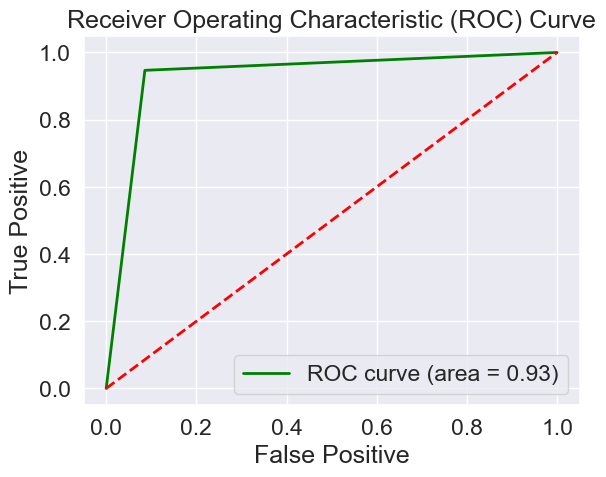

In [118]:
# roc_auc evaluation    
fpr, tpr, threshold = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


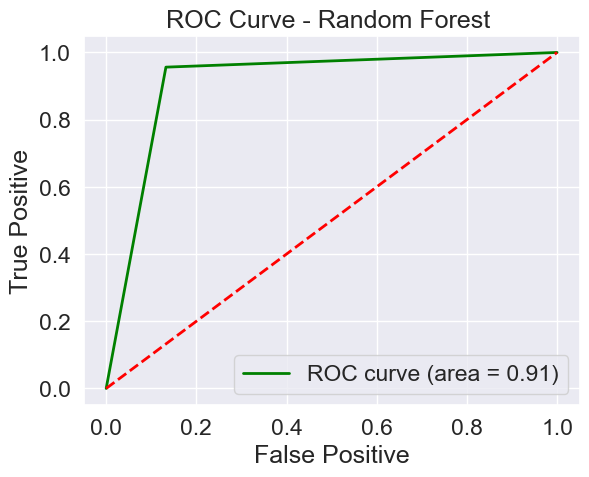

In [119]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve - Random Forest ')
plt.legend()
plt.show()


# FINAL MODEL - TESTING DATA

In [120]:
# frst 5 rows of testing data
df_test.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [121]:
# postive in test data
positive_df = df_test[df_test['Incident']=='TARGET DRUG']
positive_df.head()

,Patient-Uid,Date,Incident


In [122]:
# Extract negative test samples by identifying Patient-Uids not present in the positive DataFrame.
test_neg = df_test[df_test['Patient-Uid'].isin(positive_df['Patient-Uid'])]

# Group the test DataFrame by 'Patient-Uid' and select the last row for each patient, creating a new DataFrame.
test_df_neg = df_test.groupby('Patient-Uid').tail(1)
test_df_neg


,Patient-Uid,Date,Incident
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6
...,...,...,...
1372381,a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-01-07,DRUG_TYPE_6
1372432,a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_3
1372543,a102726b-1c7c-11ec-bfbf-16262ee38c7f,2018-12-31,DRUG_TYPE_0
1372607,a102729b-1c7c-11ec-86ba-16262ee38c7f,2019-04-02,DRUG_TYPE_3


In [123]:
test_df_neg.shape #shape of test data

(11482, 3)

In [124]:
# interval based count of previous prescriptions on test negative data
test_df_neg['no_of_prescription'] = test_df_neg.groupby('Patient-Uid')['Date'].cumcount()

In [125]:
test_df_neg.head(5)

,Patient-Uid,Date,Incident,no_of_prescription
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0


In [126]:
test_df_neg.tail(5)

,Patient-Uid,Date,Incident,no_of_prescription
1372381,a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-01-07,DRUG_TYPE_6,0
1372432,a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_3,0
1372543,a102726b-1c7c-11ec-bfbf-16262ee38c7f,2018-12-31,DRUG_TYPE_0,0
1372607,a102729b-1c7c-11ec-86ba-16262ee38c7f,2019-04-02,DRUG_TYPE_3,0
1372859,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-19,DRUG_TYPE_7,0


In [127]:
# difference between the recent prescription and the prediction date.
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
test_df_neg['Last_pres-Target'] = (prediction_date - test_df_neg.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [128]:
test_df_neg.head()

,Patient-Uid,Date,Incident,no_of_prescription,Last_pres-Target
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0,2183
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0,2710
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0,1586
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0,2717
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0,1827


In [129]:
test_df_neg.shape

(11482, 5)

In [130]:
# creating sub groups and counting non-null elements
df_test['no_of_prescription'] = df_test.groupby('Patient-Uid')['Date'].cumcount()
# finding the latest prescription date for all patients in the subgroup
df_test['Last_pres-Target'] = (prediction_date - df_test.groupby('Patient-Uid')['Date'].transform(max)).dt.days

In [131]:
# predicting test data
test_pred_xgb = XGB_Classifier.predict(df_test[['no_of_prescription', 'Last_pres-Target']]) 


In [132]:
test_pred_xgb # test data output

array([0, 1, 1, ..., 1, 1, 1])

FINAL SUBMISSION

In [133]:
# to create final submission file
Test_output_df = pd.DataFrame({'Patient-Uid': df_test['Patient-Uid'], 'Label': test_pred_xgb})
Test_output_df.head()

,Patient-Uid,Label
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1


In [134]:
Test_output_df.to_csv('Final_submission.csv', index = False) #converting dataframe into csv